In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from envs.line_world.line_world import LineWorld
from rl_algorithms.mc_algorithms.mc_es import mc_es
from rl_algorithms.mc_algorithms.mc_on_policy import mc_on_policy
from rl_algorithms.mc_algorithms.mc_off_policy import mc_off_policy

env = LineWorld(size=5, start_state=2)

# --- MC ES
Q_es, policy_es = mc_es(env, num_episodes=5000, gamma=0.99, max_steps_per_episode=None, verbose=False)
print("MC ES policy:", policy_es)

# --- On-policy MC
Q_on, policy_on = mc_on_policy(env, num_episodes=5000, gamma=0.99, epsilon=0.1, max_steps_per_episode=None, verbose=False)
print("On-policy MC policy:", policy_on.argmax(axis=1) if policy_on.ndim==2 else policy_on)

# --- Off-policy MC
Q_off, policy_off = mc_off_policy(env, num_episodes=5000, gamma=0.99, max_steps_per_episode=None, verbose=False)
print("Off-policy MC policy:", policy_off)

# --- Visualize (as arrows)
def print_policy_lineworld(policy):
    action_map = {0: "←", 1: "→", -1: "X"}
    print("Policy:", ' '.join([action_map.get(a, str(a)) for a in policy]))

print("\nMC ES:")
print_policy_lineworld(policy_es)
print("\nOn-policy MC:")
print_policy_lineworld(policy_on.argmax(axis=1) if policy_on.ndim==2 else policy_on)
print("\nOff-policy MC:")
print_policy_lineworld(policy_off)

MC ES policy: [0 1 1 1 0]
On-policy MC policy: [-1  1  1  1 -1]
Off-policy MC policy: [-1  1  1  1 -1]

MC ES:
Policy: ← → → → ←

On-policy MC:
Policy: X → → → X

Off-policy MC:
Policy: X → → → X


In [2]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))

from envs.grid_world.grid_world import GridWorld
from rl_algorithms.mc_algorithms.mc_es import mc_es
from rl_algorithms.mc_algorithms.mc_on_policy import mc_on_policy
from rl_algorithms.mc_algorithms.mc_off_policy import mc_off_policy

env = GridWorld(n_rows=4, n_cols=4, start_state=(0, 0))

Q_es, policy_es = mc_es(env, num_episodes=10000, gamma=0.99, max_steps_per_episode=400, verbose=True)
Q_on, policy_on = mc_on_policy(env, num_episodes=10000, gamma=0.99, epsilon=0.1, max_steps_per_episode=400, verbose=True)
Q_off, policy_off = mc_off_policy(env, num_episodes=10000, gamma=0.99, max_steps_per_episode=400, verbose=True)

# --- Policy visualization as arrows on the grid:
def render_policy_grid(env, policy):
    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→", -1: "X"}
    grid = np.array([[arrow_map[policy[env.state_to_index((r, c))]]
                     for c in range(env.n_cols)]
                    for r in range(env.n_rows)])
    print('\n'.join(' '.join(row) for row in grid))

print("MC ES Policy:")
render_policy_grid(env, policy_es)
print("\nOn-policy MC Policy:")
render_policy_grid(env, policy_on.argmax(axis=1) if policy_on.ndim == 2 else policy_on)
print("\nOff-policy MC Policy:")
render_policy_grid(env, policy_off)

Valid episodes (terminated): 10000/10000
Valid episodes (terminated): 9982/10000
Valid episodes (terminated): 10000/10000
MC ES Policy:
↓ → ↓ ↓
↓ ↓ ↓ ↓
→ → → ↓
→ → → ↑

On-policy MC Policy:
→ ↓ ↓ ↓
→ → → ↓
→ → ↓ ↓
→ ↑ → X

Off-policy MC Policy:
↓ ↓ ↓ ↓
↑ ↑ ↑ ↑
↑ ↑ ↑ ↑
↑ ↑ ↑ X


In [3]:
import numpy as np
import random
from envs.grid_world.grid_world import GridWorld
from rl_algorithms.mc_algorithms.mc_es import mc_es
from rl_algorithms.mc_algorithms.mc_on_policy import mc_on_policy
from rl_algorithms.mc_algorithms.mc_off_policy import mc_off_policy

env = GridWorld(n_rows=3, n_cols=3, start_state=(0, 0))

def run_mc_algo_with_random_start(mc_algo, algo_name, num_episodes=10000, gamma=0.99, epsilon=0.1, max_steps=50):
    n_states = env.n_states

    # New version : starting in a non terminate state
    def reset_random():
        possible_states = [i for i in range(n_states) if not env.is_terminal(env.index_to_state(i))]
        s_idx = random.choice(possible_states)
        s = env.index_to_state(s_idx)
        env.state = s
        return s

    Q = np.zeros((n_states, len(env.action_space)))
    policy = None

    valid_episodes = 0
    for episode in range(num_episodes):
        s = reset_random()
        episode_list = []
        steps = 0
        done = False
        while not done and steps < max_steps:
            s_idx = env.state_to_index(s)
            if algo_name == 'on_policy':
                a = np.argmax(Q[s_idx]) if random.random() > epsilon else random.choice(env.action_space)
            elif algo_name == 'off_policy':
                a = random.choice(env.action_space)
            else: # MC ES, greedy
                a = np.argmax(Q[s_idx])
            next_s, reward, done = env.simulate_step(s, a)
            episode_list.append((s_idx, a, reward))
            s = next_s
            steps += 1
        if env.is_terminal(s):
            valid_episodes += 1
            G = 0
            visited = set()
            for t in reversed(range(len(episode_list))):
                s_idx, a, r = episode_list[t]
                G = gamma * G + r
                if (s_idx, a) not in visited:
                    Q[s_idx, a] += (G - Q[s_idx, a]) / (1 + episode)
                    visited.add((s_idx, a))
    # Derive policy
    policy = np.argmax(Q, axis=1)
    print(f"{algo_name} : Valid episodes = {valid_episodes}/{num_episodes}")
    return Q, policy

# Run MC ES, On-policy, Off-policy
Q_es, policy_es = run_mc_algo_with_random_start(mc_es, 'mc_es', num_episodes=10000)
Q_on, policy_on = run_mc_algo_with_random_start(mc_on_policy, 'on_policy', num_episodes=10000, epsilon=0.1)
Q_off, policy_off = run_mc_algo_with_random_start(mc_off_policy, 'off_policy', num_episodes=10000)

def render_policy_grid(env, policy):
    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→", -1: "X"}
    grid = np.array([[arrow_map[policy[env.state_to_index((r, c))]]
                     for c in range(env.n_cols)]
                    for r in range(env.n_rows)])
    print('\n'.join(' '.join(row) for row in grid))

print("MC ES Policy:")
render_policy_grid(env, policy_es)
print("\nOn-policy MC Policy:")
render_policy_grid(env, policy_on)
print("\nOff-policy MC Policy:")
render_policy_grid(env, policy_off)

mc_es : Valid episodes = 0/10000
on_policy : Valid episodes = 9028/10000
off_policy : Valid episodes = 8993/10000
MC ES Policy:
↑ ↑ ↑
↑ ↑ ↑
↑ ↑ ↑

On-policy MC Policy:
↑ → ↓
→ → ↓
→ → ↑

Off-policy MC Policy:
→ ↓ ↓
→ → ↓
→ → ↑


In [4]:
import numpy as np
import random
from envs.rps.two_round_rps import TwoRoundRPS
from rl_algorithms.mc_algorithms.mc_es import mc_es
from rl_algorithms.mc_algorithms.mc_on_policy import mc_on_policy
from rl_algorithms.mc_algorithms.mc_off_policy import mc_off_policy

env = TwoRoundRPS()

# Monte Carlo ES
Q_es, policy_es = mc_es(env, num_episodes=10000, gamma=0.99, verbose=True)
print("MC ES policy:", policy_es)

# On-policy MC
Q_on, policy_on = mc_on_policy(env, num_episodes=10000, gamma=0.99, epsilon=0.1, verbose=True)
print("On-policy MC policy:", policy_on.argmax(axis=1) if policy_on.ndim==2 else policy_on)

# Off-policy MC
Q_off, policy_off = mc_off_policy(env, num_episodes=10000, gamma=0.99, verbose=True)
print("Off-policy MC policy:", policy_off)

def print_policy_rps(env, policy):
    action_map = {0: "Rock", 1: "Paper", 2: "Scissors", -1: "X"}
    print("Policy:")
    for idx, state in enumerate(env.states):
        print(f"State {state}: {action_map.get(policy[idx], str(policy[idx]))}")

print("\nMC ES:")
print_policy_rps(env, policy_es)
print("\nOn-policy MC:")
print_policy_rps(env, policy_on.argmax(axis=1) if policy_on.ndim==2 else policy_on)
print("\nOff-policy MC:")
print_policy_rps(env, policy_off)

Valid episodes (terminated): 10000/10000
MC ES policy: [2 1 2 0 0 0 0]
Valid episodes (terminated): 10000/10000
On-policy MC policy: [ 2  1  2  0 -1 -1 -1]
Valid episodes (terminated): 10000/10000
Off-policy MC policy: [ 1  1  2  0 -1 -1 -1]

MC ES:
Policy:
State (0, -1): Scissors
State (1, 0): Paper
State (1, 1): Scissors
State (1, 2): Rock
State (2, 0): Rock
State (2, 1): Rock
State (2, 2): Rock

On-policy MC:
Policy:
State (0, -1): Scissors
State (1, 0): Paper
State (1, 1): Scissors
State (1, 2): Rock
State (2, 0): X
State (2, 1): X
State (2, 2): X

Off-policy MC:
Policy:
State (0, -1): Paper
State (1, 0): Paper
State (1, 1): Scissors
State (1, 2): Rock
State (2, 0): X
State (2, 1): X
State (2, 2): X


In [5]:
from envs.monty_hall.monty_hall_v1 import MontyHallV1

env = MontyHallV1()

Q_es, policy_es = mc_es(env, num_episodes=20000, gamma=0.99, verbose=True)
Q_on, policy_on = mc_on_policy(env, num_episodes=20000, gamma=0.99, epsilon=0.1, verbose=True)
Q_off, policy_off = mc_off_policy(env, num_episodes=20000, gamma=0.99, verbose=True)

def print_policy_monty(env, policy):
    action_map = {0: "Choose0/Stay", 1: "Choose1/Switch", 2: "Choose2", 3: "Stay", 4: "Switch", -1: "X"}
    print("Policy:")
    for idx, state in enumerate(env.states):
        print(f"State {state}: {action_map.get(policy[idx], str(policy[idx]))}")

print("\nMC ES:")
print_policy_monty(env, policy_es)
print("\nOn-policy MC:")
print_policy_monty(env, policy_on.argmax(axis=1) if policy_on.ndim==2 else policy_on)
print("\nOff-policy MC:")
print_policy_monty(env, policy_off)

Valid episodes (terminated): 20000/20000
Valid episodes (terminated): 20000/20000
Valid episodes (terminated): 20000/20000

MC ES:
Policy:
State (0, -1, -1): Choose0/Stay
State (1, 0, 1): Choose0/Stay
State (1, 0, 2): Choose0/Stay
State (1, 1, 0): Choose0/Stay
State (1, 1, 2): Choose0/Stay
State (1, 2, 0): Choose0/Stay
State (1, 2, 1): Choose0/Stay
State (2, 0, -1): Choose0/Stay
State (2, 1, -1): Choose0/Stay
State (2, 2, -1): Choose0/Stay

On-policy MC:
Policy:
State (0, -1, -1): Choose0/Stay
State (1, 0, 1): Choose1/Switch
State (1, 0, 2): Choose1/Switch
State (1, 1, 0): Choose1/Switch
State (1, 1, 2): Choose1/Switch
State (1, 2, 0): Choose1/Switch
State (1, 2, 1): Choose1/Switch
State (2, 0, -1): X
State (2, 1, -1): X
State (2, 2, -1): X

Off-policy MC:
Policy:
State (0, -1, -1): Choose1/Switch
State (1, 0, 1): Choose1/Switch
State (1, 0, 2): Choose1/Switch
State (1, 1, 0): Choose1/Switch
State (1, 1, 2): Choose1/Switch
State (1, 2, 0): Choose1/Switch
State (1, 2, 1): Choose1/Switch

Politique apprise (état : action recommandée) :
  État (0, (0, 1, 2, 3, 4), -1) : 0
  État (1, (0, 2, 3, 4), 0) : 2
  État (1, (0, 1, 3, 4), 0) : 1
  État (1, (0, 1, 2, 4), 0) : 2
  État (1, (0, 1, 2, 3), 0) : 2
  État (1, (0, 1, 3, 4), 1) : 1
  État (1, (0, 1, 2, 4), 1) : 2
  État (1, (0, 1, 2, 3), 1) : 2
  État (1, (1, 2, 3, 4), 1) : 1
  État (1, (0, 2, 3, 4), 2) : 2
  État (1, (0, 1, 2, 4), 2) : 0
  État (1, (0, 1, 2, 3), 2) : 3
  État (1, (1, 2, 3, 4), 2) : 3
  État (1, (0, 2, 3, 4), 3) : 2
  État (1, (0, 1, 3, 4), 3) : 4
Politique optimale (état : action optimale) :
  État (0, (0, 1, 2, 3, 4), -1) : 0
  État (1, (0, 2, 3, 4), 0) : 2
  État (1, (0, 1, 3, 4), 0) : 1
  État (1, (0, 1, 2, 4), 0) : 1
  État (1, (0, 1, 2, 3), 0) : 1
  État (1, (0, 1, 3, 4), 1) : 0
  État (1, (0, 1, 2, 4), 1) : 0
  État (1, (0, 1, 2, 3), 1) : 0
  État (1, (1, 2, 3, 4), 1) : 2
  État (1, (0, 2, 3, 4), 2) : 0
  État (1, (0, 1, 2, 4), 2) : 0
  État (1, (0, 1, 2, 3), 2) : 0
  État (1, (1, 2, 3, 4), 2) : 1
  

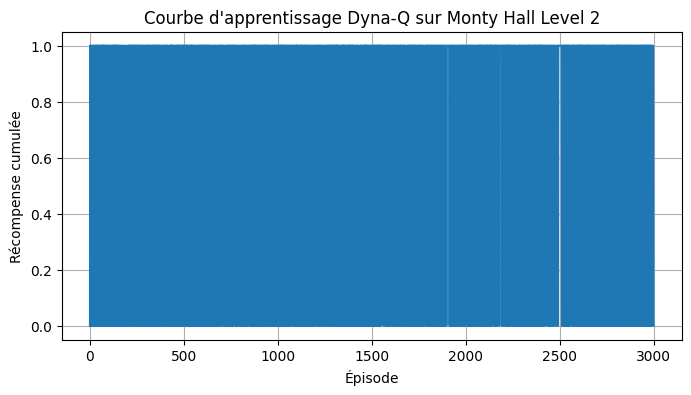

Nombre d'actions explorées (aléatoires) : 1153
Nombre d'actions exploitées (greedy) : 10847
Taux d'exploration : 9.61%


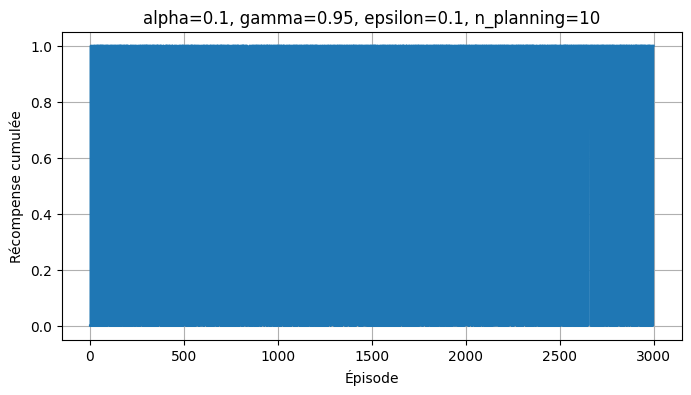

Valid episodes (terminated): 40000/40000
Valid episodes (terminated): 40000/40000
Valid episodes (terminated): 40000/40000

MC ES:
Policy:
State (0, (0, 1, 2, 3, 4), -1): action 0
State (1, (0, 2, 3, 4), 0): action 0
State (1, (0, 1, 3, 4), 0): action 0
State (1, (0, 1, 2, 4), 0): action 0
State (1, (0, 1, 2, 3), 0): action 0
State (1, (0, 1, 3, 4), 1): action 0
State (1, (0, 1, 2, 4), 1): action 0
State (1, (0, 1, 2, 3), 1): action 0
State (1, (1, 2, 3, 4), 1): action 1
State (1, (0, 2, 3, 4), 2): action 0
State (1, (0, 1, 2, 4), 2): action 0
State (1, (0, 1, 2, 3), 2): action 0
State (1, (1, 2, 3, 4), 2): action 1
State (1, (0, 2, 3, 4), 3): action 0
State (1, (0, 1, 3, 4), 3): action 0
State (1, (0, 1, 2, 3), 3): action 0
State (1, (1, 2, 3, 4), 3): action 1
State (1, (0, 2, 3, 4), 4): action 0
State (1, (0, 1, 3, 4), 4): action 0
State (1, (0, 1, 2, 4), 4): action 0
State (1, (1, 2, 3, 4), 4): action 1
State (2, (0, 3, 4), 0): action 0
State (2, (0, 2, 4), 0): action 0
State (2, (0

In [6]:
from envs.monty_hall.monty_hall_v2 import MontyHallV2

env = MontyHallV2(n_doors=5)  # 5 doors

Q_es, policy_es = mc_es(env, num_episodes=40000, gamma=0.99, verbose=True)
Q_on, policy_on = mc_on_policy(env, num_episodes=40000, gamma=0.99, epsilon=0.1, verbose=True)
Q_off, policy_off = mc_off_policy(env, num_episodes=40000, gamma=0.99, verbose=True)

def print_policy_monty_v2(env, policy):
    print("Policy:")
    for idx, state in enumerate(env.states):
        print(f"State {state}: action {policy[idx]}")

print("\nMC ES:")
print_policy_monty_v2(env, policy_es)
print("\nOn-policy MC:")
print_policy_monty_v2(env, policy_on.argmax(axis=1) if policy_on.ndim == 2 else policy_on)
print("\nOff-policy MC:")
print_policy_monty_v2(env, policy_off)
